<a href="https://colab.research.google.com/github/ShivaKondapalli/Invariance/blob/master/FinetuningVFeatureExtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import time
import torch
import matplotlib.pyplot as plt
from torchvision import models, datasets, transforms
from torch import optim 
import torch.nn as nn
import copy
import numpy as np
import zipfile
# import visdom
torch.manual_seed(3)

In [4]:
if torch.cuda.is_available():
  print('The power of the GPU is with you!')
else:
  print('run for eternity on the CPU')

The power of the GPU is with you!


In [5]:
# list of models to choose from 

Models = ['resnet', 'alexnet', 'densenet', 'squeezenet', 'inception', 'vgg']
Models

num_epochs = 15
model_name = 'squeezenet'
num_classes = 10
feature_extract=True

  
# datasets, data trasnforms and dataloaders
data_transforms = {
        'train': transforms.Compose([
            transforms.RandomRotation(45),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ]),
        'valid': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])])
}

trainset = datasets.CIFAR10(root='/.data', download=True, train=True, transform=data_transforms['train'])

validset = datasets.CIFAR10(root='/.data', download=True, train=False, transform=data_transforms['valid'])

datasets_dict = {'train': trainset, 'valid': validset}
dataloaders_dict = {x: torch.utils.data.DataLoader(datasets_dict[x], batch_size=100, shuffle=True) for x in
                    ['train', 'valid']}
dataset_size = {x: len(dataloaders_dict[x].dataset) for x in ['train', 'valid']}

0it [00:00, ?it/s]

100%|█████████▉| 170156032/170498071 [00:49<00:00, 4163409.62it/s]

Files already downloaded and verified


In [0]:
def train_model(model, dataloaders, optimizer, criterion, num_epochs, is_inception, device='cuda'):
  
    """trains model and retunrs model state_dict and loss and accuracy for train and validation"""

    start = time.time()

    # train loss and accuracy
    train_loss_history = []
    train_acc_history = []

    # valdiation loss and accuracy
    val_loss_history = []
    val_acc_history = []

    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'=='*20)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in dataloaders[phase]:

                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):

                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model.forward(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 =criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2

                    else:
                        outputs = model.forward(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = outputs.max(dim=1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)

            epoch_loss = running_loss/dataset_size[phase]
            epoch_acc = running_corrects.double()/dataset_size[phase]

            print("{} Loss: {} Acc: {}".format(phase, epoch_loss, epoch_acc))

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            elif phase == 'valid':
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

    time_elapsed = time.time() - start
    print('Time taken to train {:.0f}m {:0f}s'.format(time_elapsed//60, time_elapsed % 60))
    print('best val acc:'.format(best_acc))
    model.load_state_dict(best_model_wts)

    return best_model_wts, train_loss_history, val_loss_history, train_acc_history, val_acc_history

In [7]:
# keep the in_features of the fc layer the same as the original pre-trained model but change the num_of_classes according to the classes of the dataset bneing used.

def set_parameters_grad(model, feature_extracting):
  if feature_extracting:
    for param in model.parameters():
      param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
  
  model_ft= None
  input_size = 0
  
  if model_name == 'resnet':
    """Resent34"""
    
    model_ft= models.resent34(pretrained=use_pretrained)
    set_parameters_grad(model_ft, feature_extract)
    num_features = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_features, num_classes)
    input_size = 224
    
  elif model_name == 'vgg':
    
    """vgg11_bn"""
    
    model_ft = models.vgg11_bn(pretrained=use_pretrained)
    set_parameters_grad(model_ft, feature_extract)
    num_features = modelf_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_features, num_classes)
    input_size = 224
    
  elif  model_name == 'alexnet':
    """Alexnet"""
    
    model_ft = models.alexnet(pretrained=use_pretrained)
    set_parameters_grad(model_ft, feature_extract)
    num_features = modelf_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_features, num_classes)
    input_size = 224
    
  elif model_name == 'squeezenet':
    """Squeezenet"""
    
    model_ft = models.squeezenet1_0(pretrained=use_pretrained)
    set_parameters_grad(model_ft, feature_extract)
    model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
    model_ft.num_classes = num_classes
    input_size = 224
    
  elif model_name == 'densenet':
    
    """Densenet"""
    
    model_ft = models.densenet121(pretrained=use_pretrained)
    set_parameters_grad(model_ft, feature_extract)
    num_features = model_ft.classifier.in_features
    model_ft.classifier = nn.Linear(num_features, num_classes)
    input_size = 224
    
    
  elif model_name  == 'inception':
    """Inception v 3"""
    
    model_ft  = models.inception_v3(pretrained = use_trained)
    set_parameters_grad(model_ft, feature_extract)
    aux_features = moel_ft.AuxLogits.fc.in_features 
    model_ft.AuxLogits.fc = nn.Linear(aux_features, num_classes)
    num_features = model_ft.fc.in_feautres
    model_ft.fc = nn.Linear(num_features, num_classes)
    input_size= 229
    
  else:
    print("Invalid model name, exiting...")
    exit()

  return model_ft, input_size

# Calling initialize model
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

model_ft.to('cuda')



params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /root/.torch/models/squeezenet1_0-a815701f.pth

0it [00:00, ?it/s]
2981888it [00:00, 29813719.49it/s]
5017600it [00:00, 28861098.35it/s]

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


In [8]:
# Call model

criterion = nn.CrossEntropyLoss()
model_ft, train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(model_ft, dataloaders_dict, optimizer_ft, criterion, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 1/20
train Loss: 1.6602560007572174 Acc: 0.40064000000000005
valid Loss: 1.088328607082367 Acc: 0.6301
Epoch 2/20
train Loss: 1.447669602394104 Acc: 0.48310000000000003
valid Loss: 0.9219164431095124 Acc: 0.6847000000000001
Epoch 3/20
train Loss: 1.3938243036270141 Acc: 0.5020600000000001
valid Loss: 0.8557472091913223 Acc: 0.7024
Epoch 4/20
train Loss: 1.3716035406589508 Acc: 0.5118400000000001
valid Loss: 0.8192527973651886 Acc: 0.7173
Epoch 5/20
train Loss: 1.3624547047615052 Acc: 0.5142800000000001
valid Loss: 0.7948238521814346 Acc: 0.7278
Epoch 6/20
train Loss: 1.3453936002254485 Acc: 0.51814
valid Loss: 0.7752675634622573 Acc: 0.73
Epoch 7/20
train Loss: 1.3424471341371536 Acc: 0.52122
valid Loss: 0.7632105588912964 Acc: 0.7346
Epoch 8/20
train Loss: 1.3364711594581604 Acc: 0.5231600000000001
valid Loss: 0.7657417732477189 Acc: 0.7345
Epoch 9/20
train Loss: 1.3257850618362428 Acc: 0.5279200000000001
valid Loss: 0.7692938357591629 Acc: 0.7288
Epoch 10/20
train Loss: 1.32781

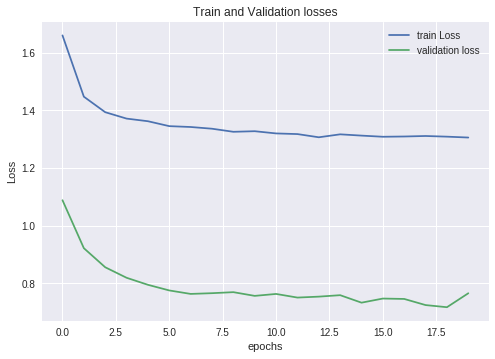

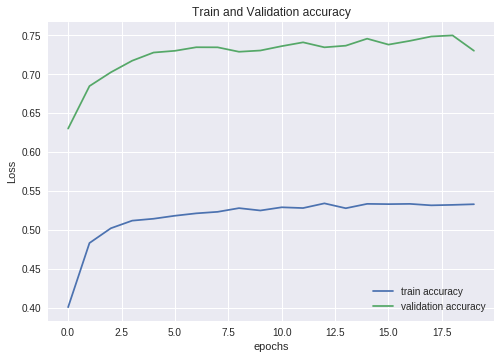

In [9]:
# Visualize train and validation losses
def plot_train_val_loss(train_loss, val_loss):
  plt.plot(train_loss, label='train Loss')
  plt.plot(val_loss, label='validation loss')
  plt.title('Train and Validation losses')
  plt.xlabel('epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  
# Visualize train_accuracy and validation accuracy
def plot_train_val_acc(train_acc, val_acc):
  plt.plot(train_acc, label='train accuracy')
  plt.plot(val_acc, label='validation accuracy')
  plt.title('Train and Validation accuracy')
  plt.xlabel('epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  
plot_train_val_loss(train_loss_history, val_loss_history)
plot_train_val_acc(train_acc_history, val_acc_history)